# Loss in Trees Ensembles

I'll evaluate the error in the predictions of two tree-ensembles, Random Forest and AdaBoost, as a function of the number of trees.

We'll see the error value also as a function of two other parameters: the maximum depth of the trees and the number of samples used for each tree.

All this, while comparing the performance on the train set to the one on the test set. In order to keep it almost as simple as possible, I'll use the _hello world_ dataset: Titanic.

In [923]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [801]:
df = pd.read_csv("train.csv")

In [802]:
df.Cabin.fillna(value="null", inplace=True)
df.Sex = df.Sex.apply(lambda x: 1 if x=="female" else 0)

In [803]:
train, test = train_test_split(df, random_state=0)

In [804]:
X_train = train.drop(columns="Survived")
y_train = train.Survived
X_test = test.drop(columns="Survived")
y_test = test.Survived

As I want to focus on the Error evaluation for different models and models' hyper-parameters, 
I'll do an extremely basic preprocessing. I'll fill null values in "Age" with the mean and in "Embarked" with the majority. I'll even drop some categorical features and encode "Embarked" using the one-hot technique.

In [805]:
mean_age = X_train.Age.mean()
majority_embarked = X_train.Embarked.value_counts().index[0]

In [806]:
X_train.Age.fillna(value=mean_age, inplace=True)
X_test.Age.fillna(value=mean_age, inplace=True)
X_train.Embarked.fillna(value=majority_embarked, inplace=True)
X_test.Embarked.fillna(value=majority_embarked, inplace=True)

In [807]:
[elem for elem in X_test.Embarked.unique() if elem not in X_train.Embarked.unique()]

[]

In [808]:
train_embarked_dummies = pd.get_dummies(X_train.Embarked, prefix="Embarked")
test_embarked_dummies = pd.get_dummies(X_test.Embarked, prefix="Embarked")

X_train = pd.concat([X_train, train_embarked_dummies], axis=1)
X_test = pd.concat([X_test, test_embarked_dummies], axis=1)

In [809]:
X_train.drop(columns=["Name","Ticket", "Cabin", "Embarked"], inplace=True)
X_test.drop(columns=["Name","Ticket", "Cabin", "Embarked"], inplace=True)

After the preprocessing is done, we can fit-predict.

In [916]:
random_forest = RandomForestClassifier()

In [917]:
adaboost = AdaBoostClassifier()

In [883]:
def get_train_and_test_accuracy(model):
    model.fit(X_train, y_train)
    train_prediction = model.predict(X_train)
    test_prediction = model.predict(X_test)
    return accuracy_score(y_train, train_prediction), accuracy_score(y_test, test_prediction)

I define two Pandas Dataframes where I will store the results of the evaluation. One for each model.

In [939]:
df_stats_random_forest = pd.DataFrame(columns = ["set","number of trees",'depth',"loss", "samples_num"])

In [940]:
df_stats_adaboost = pd.DataFrame(columns = ["set","number of trees","depth", "loss"])

The hyper-parameters that are being tuned: depth of the trees, number of samples used for each one, number of trees.

In [941]:
depth_range = (5, 10, 15)
samples_range = (0.5, 0.99)
estimators_range = range(1,200, 20)

I will use the 0-1 loss function. That is, for every prediction we'll look at the value of [1 - Acc], where Acc stands for the accuracy of the prediction.

I'll do it through nested loops. First for Random Forest, then for AdaBoost.

In [942]:
for depth in depth_range:
    for samples_num in samples_range:
        for n_estimators in estimators_range:
            random_forest.set_params(max_depth=depth)
            random_forest.set_params(max_samples=samples_num)
            random_forest.set_params(n_estimators = n_estimators)
            train_acc, test_acc = get_train_and_test_accuracy(random_forest)
            df_stats_random_forest.loc[len(df_stats_random_forest)] = ["train", n_estimators, depth, 1-train_acc, samples_num]
            df_stats_random_forest.loc[len(df_stats_random_forest)] = ["test", n_estimators, depth, 1-test_acc, samples_num]

In [943]:
for depth in depth_range:
    for n_estimators in estimators_range:
        adaboost.set_params(base_estimator = DecisionTreeClassifier(max_depth=depth))
        adaboost.set_params(n_estimators = n_estimators)
        train_acc, test_acc = get_train_and_test_accuracy(adaboost)
        df_stats_adaboost.loc[len(df_stats_adaboost)] = ["train", n_estimators, depth, 1-train_acc]
        df_stats_adaboost.loc[len(df_stats_adaboost)] = ["test", n_estimators, depth, 1-test_acc]

And we'll see the results:

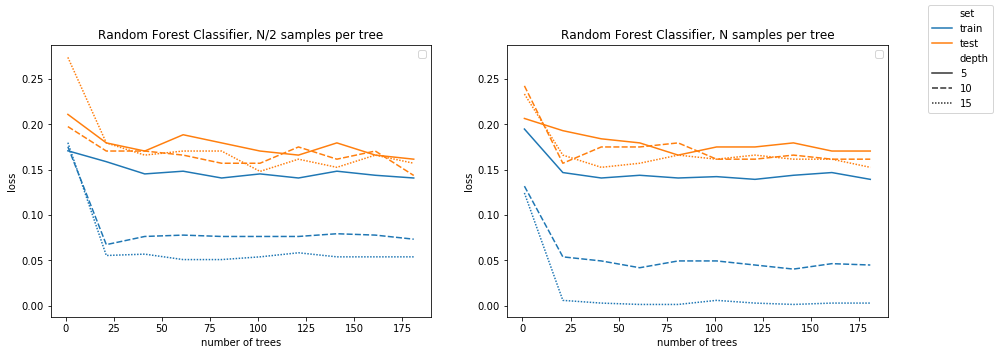

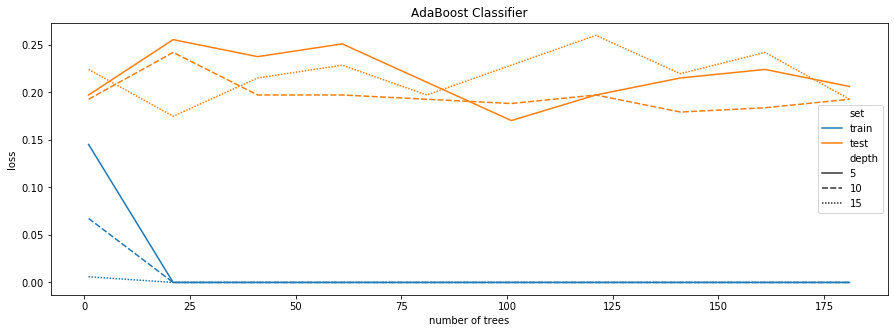

In [944]:
fig = plt.figure(figsize=(15,5))

ax1 = plt.subplot(1, 2, 1)
ax1 = sns.lineplot(x="number of trees", y="loss",  style="depth", hue="set", data=df_stats_random_forest[df_stats_random_forest.samples_num==0.5])

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
ax2 = sns.lineplot(x="number of trees", y="loss",  style="depth", hue="set", data=df_stats_random_forest[df_stats_random_forest.samples_num!=0.5])

handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels)

ax1.legend('')
ax2.legend('')

ax1.set_title("Random Forest Classifier, N/2 samples per tree")
_ = ax2.set_title("Random Forest Classifier, N samples per tree")

plt.show()

fig = plt.figure(figsize=(15,5))
_ = sns.lineplot(x="number of trees", y="loss", style="depth", hue="set", data=df_stats_adaboost)
_ = plt.title("AdaBoost Classifier")

As we can see, increasing the number of trees doesn't lead to overfitting on any of the two models. The graphs corresponding to the the test sets gets more or less constant after the first step. Furthermore, apparently there ain't overfitting even when increasing two important hyper parameters: the maximum depth of the trees and the number of samples taken for calculating them (this last one, in Random Forest only).